In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bluebelt.helpers import defaults
import scipy.stats as stats
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'bluebelt.styles.blue'

In [ ]:
df = pd.read_excel('data/data.xlsx', sheet_name='data')

In [ ]:
dfx = df.pivot_table(values='hours', index='date', columns='department')
dfx = dfx[['pick','pack']].dropna()

In [4]:
def control_chart(s, **kwargs):
    
    # calculations
    std = s.std()
    mean = s.mean()
    
    fig, ax = plt.subplots(**kwargs)
    
    # observations
    ax.plot(s, marker='o')
    
    # mean
    ax.axhline(mean, color='#000000', linestyle='--', linewidth=1)
    ax.text(s.index.max(), mean, f'mean = {mean:1.2f}', ha='left', va='bottom', fontsize=10)
    
    # control limits
    ax.axhline(mean+std*3, color='#FF0000', linestyle='--', linewidth=1)
    ax.axhline(mean-std*3, color='#FF0000', linestyle='--', linewidth=1)
    
    ax.text(s.index.max(), mean+std*3, f'UCL = {mean+std*3:1.2f}', ha='left', va='bottom')
    ax.text(s.index.max(), mean-std*3, f'LCL = {mean-std*3:1.2f}', ha='left', va='bottom')
    
    # labels
    ax.set_title(f'control chart of {s.name}')
    ax.set_xlabel(s.index.name)
    ax.set_ylabel('value')
    
    #ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    plt.close()
    
    return fig

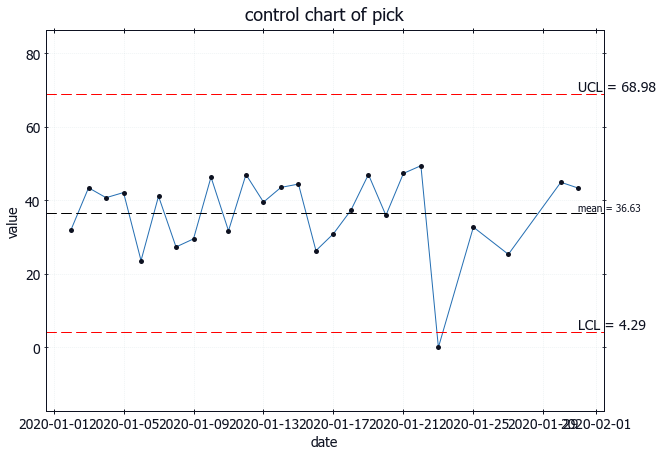

In [5]:
control_chart(dfx['pick'])

In [41]:
class ControlChart():
    
    def __init__(self, series, **kwargs):
        
        self.series = series
        
        self.calculate()
        
    def __str__(self):
        
        return 


    def __repr__(self):
        return (f'{self.__class__.__name__}(mean={self.mean:1.1f}, std={self.std:1.1f}, UCL={self.ucl:1.1f}, LCL={self.lcl:1.1f}, outlier_count={self.outlier_count:1.0f})')
    
    def calculate(self):
        mean = self.series.mean()
        std = self.series.std()
        ucl = mean + std * 3
        lcl = mean - std * 3
        outliers = self.series[(self.series > ucl) | (self.series < lcl)]
        
        self.mean = mean
        self.std = std
        self.ucl = ucl
        self.lcl = lcl
        self.outliers = outliers
        self.outlier_count = outliers.shape[0]
        
    def plot(self, **kwargs):
        
        fig, ax = plt.subplots(**kwargs)

        # observations
        ax.plot(self.series, marker='o', mfc=defaults.blue, color=defaults.light_blue)
        
        # outliers
        ax.plot(self.outliers, ls=None, marker='o', markerfacecolor=defaults.red)
        
        # mean
        ax.axhline(self.mean, color=(0,0,0,1), linestyle='--', linewidth=1)
        ax.text(self.series.index.max(), self.mean, f'mean = {self.mean:1.2f}', ha='right', va='bottom', fontsize=10)

        # control limits
        ax.axhline(self.ucl, color=defaults.red, linestyle='--', linewidth=1)
        ax.axhline(self.lcl, color=defaults.red, linestyle='--', linewidth=1)

        ax.text(self.series.index.max(), self.ucl, f'UCL = {self.ucl:1.2f}', ha='right', va='bottom', fontsize=defaults.xsmall)
        ax.text(self.series.index.max(), self.lcl, f'LCL = {self.lcl:1.2f}', ha='right', va='bottom', fontsize=defaults.xsmall)

        # labels
        ax.set_title(f'control chart of {self.series.name}', fontsize=defaults.large)
        ax.set_xlabel(self.series.index.name, fontsize=defaults.small)
        ax.set_ylabel('value', fontsize=defaults.small)

        #ax.spines['top'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        #ax.spines['right'].set_visible(False)
        plt.close()

        return fig
    
    def plotly(self):
        
        config = dict({
            'scrollZoom': False,
            'displayModeBar': True,
            'editable': True
        })
        
        
        layout = go.Layout(
            title=f'control chart of {self.series.name}',    
            plot_bgcolor=f'rgba{defaults.rgb_white+(1,)}',
            hovermode="closest",
            xaxis=dict(
                title=self.series.index.name,
                linecolor=f'rgba{defaults.rgb_light_grey+(1,)}',
                zeroline=False,
                ticks="outside",
                tickwidth=1,
                tickcolor=f'rgba{defaults.rgb_light_grey+(1,)}',
                ticklen=5,
                showgrid=True,
                gridwidth=0.5,
                gridcolor=f'rgba{defaults.rgb_light_grey+(1,)}',
            ),
            yaxis=dict(
                title="value",
                linecolor=f'rgba{defaults.rgb_light_grey+(1,)}',
                zeroline=False,
                ticks="outside",
                tickwidth=1,
                tickcolor=f'rgba{defaults.rgb_light_grey+(1,)}',
                ticklen=5,
                showgrid=True,
                gridwidth=0.5,
                gridcolor=f'rgba{defaults.rgb_light_grey+(1,)}',
            ),
        )
        
        data = [go.Scatter(
                        x=self.series.index,
                        y=self.series.values,
                        line=dict(
                                width=3,
                                color=f'rgba{defaults.rgb_light_blue+(1,)}',
                            ),
                        marker=dict(
                            color=f'rgba{defaults.rgb_blue+(1,)}',
                            size=9,
                        ),
                        mode='lines+markers',
                        showlegend=False,
                        name=self.series.name,
                    ),
                go.Scatter(
                        x=self.outliers.index,
                        y=self.outliers.values,
                        marker=dict(
                            color=f'rgba{defaults.rgb_red+(1,)}',
                            size=9,
                        ),
                        mode='markers',
                        showlegend=False,
                        name='outliers'
                    ),
               ]
    
        fig = go.Figure(data=data, layout=layout)
    
    
        # add mean, UCL and LCL line
        fig.add_shape(
                type="line",
                xref="paper",
                yref="y",
                x0=0,
                y0=self.mean,
                x1=1,
                y1=self.mean,
                line=dict(
                    color=f'rgba{defaults.rgb_grey+(1,)}',
                    width=3,
                    dash='dash'
                ),
            )
        fig.add_shape(
                type="line",
                xref="paper",
                yref="y",
                x0=0,
                y0=self.ucl,
                x1=1,
                y1=self.ucl,
                line=dict(
                    color=f'rgba{defaults.rgb_grey+(1,)}',
                    width=3,
                    dash='dash'
                ),
            )
        fig.add_annotation(
            dict(
                xref="paper",
                yref="y",
                x=1,
                y=self.ucl,
                text="UCL",
                showarrow=False,
                align='right',
                bgcolor=f'rgba{defaults.rgb_white+(0.7,)}',
            )
        )
        fig.add_shape(
                type="line",
                xref="paper",
                yref="y",
                x0=0,
                y0=self.lcl,
                x1=1,
                y1=self.lcl,
                line=dict(
                    color=f'rgba{defaults.rgb_grey+(1,)}',
                    width=3,
                    dash='dash'
                ),
            )
        fig.add_annotation(
            dict(
                xref="paper",
                yref="y",
                x=1,
                y=self.lcl,
                text="LCL",
                showarrow=False,
                align='right',
                bgcolor=f'rgba{defaults.rgb_white+(0.7,)}',
            )
        )
        # x-ticks to nice datetime format
        if isinstance(self.series.index, pd.DatetimeIndex):
            fig.update_layout(xaxis_tickformat = '%d-%m-%Y')
        
        
        return fig.show(config=config)

In [44]:
ControlChart(dfx['pick']).plotly()

In [33]:
ControlChart(dfx['pick'], alpha=2)

ControlChart(mean=36.6, std=10.8, UCL=69.0, LCL=4.3, outlier_count=1)

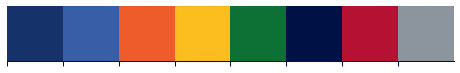

In [8]:
sns.palplot(sns.color_palette())

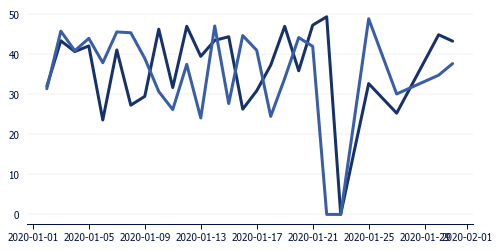

In [18]:
plt.plot(dfx['pick'])
plt.plot(dfx['pack'])


In [21]:
dfx['pack'].shape[0]

26